In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [172]:
class GP_Normal:
    
    def __init__(self, X, y, sigmaN=0, l=1, sigma=1):
        
        self.X = X
        self.y = y
        self.K = self.kernel_Gauss( X, X , l, sigma)
        if sigmaN != 0:
            self.K += np.eye( X.shape[0] ) * sigmaN
        
        return
    
    def kernel_Gauss_1(self, X1, X2, l=1, sigma=1):
        '''
        Note that this is the isotropic formulation of the system.
        '''
        
        if X1.shape[0] < X2.shape[0]:
            K = np.array([ (np.exp( -(0.5/l**2)*((X2 - x)**2).sum(axis=1))) for x in X1 ])
            K *= sigma**2
        else:
            K = np.array([ (np.exp( -(0.5/l**2)*((X1 - x)**2).sum(axis=1))) for x in X2 ])
            K *= sigma**2
            K = K.T
        
        return K
    
    def kernel_Gauss(self, X1, X2, l=1, sigma=1):
        '''
        Note that this is the isotropic formulation of the system.
        '''
        
        K = np.zeros( (X1.shape[0], X2.shape[0] ))
        
        for i, x1 in enumerate(X1):
            for j, x2 in enumerate(X2):
                K[i][j] = ((x1 - x2)**2).sum()
                
        K = (sigma**2)*np.exp( -(0.5/l**2)*K )
        
        return K
    
    def sampleX(self, XNew, NSamples=1, *args, **kwargs):
        
        KNew    = self.kernel_Gauss(XNew, XNew, *args, **kwargs) + 1e-8 * np.eye(len(XNew))
        KOldNew = self.kernel_Gauss(self.X, XNew, *args, **kwargs)
        
        #print(self.K.shape, KNew.shape, KOldNew.shape)
        
        muNew    = KOldNew.T @ np.linalg.inv(self.K) @ self.y.reshape(-1, 1)
        SigmaNew = KNew - KOldNew.T @ np.linalg.inv(self.K) @ KOldNew
        
        yNew = np.random.multivariate_normal(muNew.flatten(), SigmaNew, NSamples)
        
        return yNew
    
    def muSig(self, XNew, NSamples=100, *args, **kwargs):
        
        yNew = self.sampleX(XNew, NSamples, *args, **kwargs)
        std   = yNew.std(axis=0)
        mean  = yNew.mean(axis=0)
        
        return mean, std
    
    def PI(self, XNew, NSamples=100, epsilon=1e-8, *args, **kwargs):
        
        yNew = self.sampleX(XNew, NSamples, *args, **kwargs)
        std   = yNew.std(axis=0)
        mean  = yNew.mean(axis=0)
        
        pi = norm.sf( self.y.max(), loc=mean, scale=std )
        
        return pi
    
    def updatePI(self, XNew, NSamples=100, epsilon=1e-8, *args, **kwargs):
        
        pi = self.PI( XNew, NSamples=100, epsilon=1e-8, *args, **kwargs )
        pi_maxPos = np.where( pi == pi.max() )[0][0]
        
        XNewVal = XNew[ pi_maxPos ]
        
        return XNewVal
    

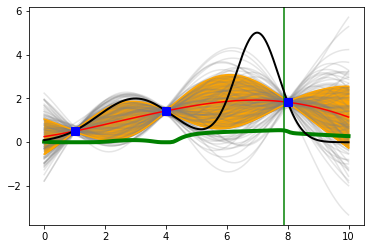

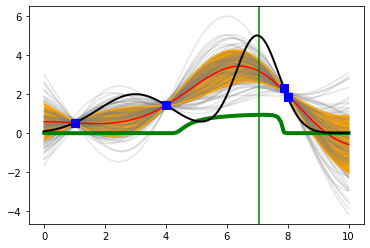

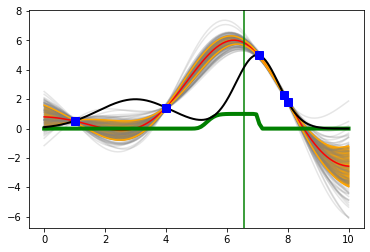

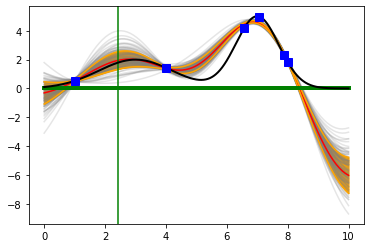

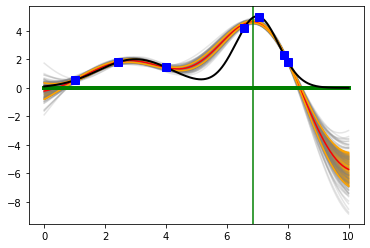

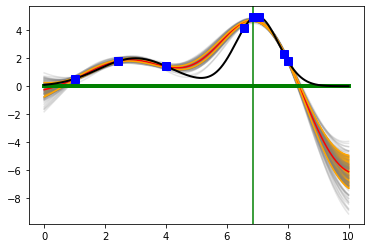

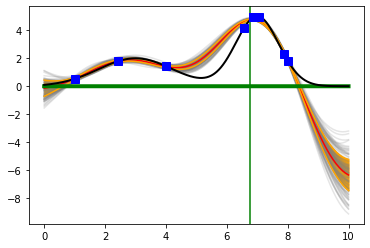

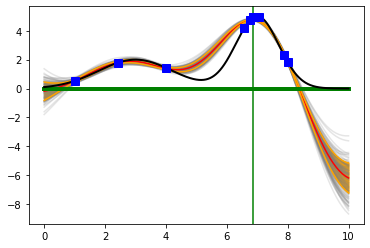

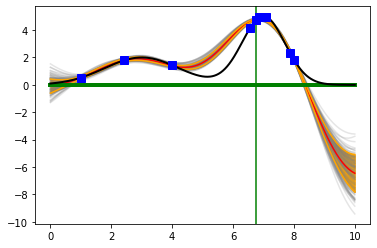

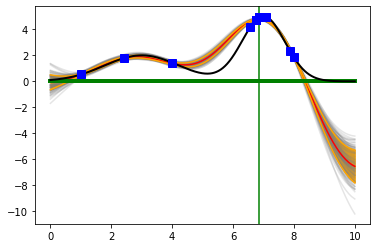

In [176]:
D = 1
l = 2
sigma=2


XAll = np.linspace(0, 10, 1000).reshape(-1, 1)
yAll = 2*np.exp( -(XAll -3)**2/(3) ) + 5*np.exp( -(XAll -7)**2/(1) )

# Samples ...
X = np.array([[ 1, 4, 8 ]]).T
X = np.array([[ 1, 4, 8 ]]).T
y = 2*np.exp( -(X -3)**2/(3) ) + 5*np.exp( -(X -7)**2/(1) )

XNew = np.linspace(0, 10, 100).reshape(-1, 1)
gp = GP_Normal(X, y, 0.01, l, sigma)



for i in range(10):
        
    
    mu, sig = gp.muSig(XNew, 100,    sigma=sigma, l=l)
    pi = gp.PI(XNew, 100,            sigma=sigma, l=l)
    XNewVal = gp.updatePI(XNew, 100, sigma=sigma, l=l)
    
    yNews = gp.sampleX(XNew, 100, sigma=sigma, l=l)
    
    
    
    
    plt.figure()
    
    for yN in yNews:
        plt.plot(XNew[:, 0], yN, color=(0.5, 0.5, 0.5), alpha=0.2)

    plt.plot( XNew[:, 0], mu.flatten(), color='red' )
    plt.fill_between( XNew[:, 0], mu.flatten() + sig.flatten(), mu.flatten() - sig.flatten(), color='orange', facecolor='red')
    plt.plot(XNew[:, 0], mu.flatten() + sig.flatten(), color='orange')
    plt.plot(XNew[:, 0], mu.flatten() - sig.flatten(), color='orange')

    plt.plot(XNew[:, 0], pi, color='green', lw=4)
    plt.axvline(XNewVal[0], C='green')

    plt.plot(XAll[:, 0], yAll[:, 0], lw=2, color='k')
    plt.plot(X[:, 0], y[:, 0], 's', mfc='blue', mec='blue', ms=8)
    
    plt.show()
    plt.close('all')
    
    X = np.vstack((X, XNewVal))
    y = 2*np.exp( -(X -3)**2/(3) ) + 5*np.exp( -(X -7)**2/(1) )
    
    gp = GP_Normal(X, y, 0.01, l, sigma)
    
    
    